In [1]:
# Import necessary dependencies

import os
import sys
import pandas as pd
os.chdir(os.path.dirname(os.getcwd())) # Set root folder to project root
sys.path.append(os.getcwd()) # Add root folder to path
from src.utils.config import TDAParameters
from src.utils.tda import (
    tda,
    get_diagram,
    get_max_finite_death,
    plot_diagram,
    get_betti_nums,
    add_betti_column,
    make_betti_table,
    sample_circle,
    sample_square,
    sample_sphere,
    sample_torus
)
import torch
import numpy as np
from IPython.display import HTML

# For plotting in Jupyter Notebook
%matplotlib notebook
import plotly.express as px

In [2]:
# #Perform TDA
# params = TDAParameters()
# params.model_name = [
#     'models/dt_net/original.pth',
#     'models/dt_net/2025-04-17_13:30:06/best.pth',  # trained on percolation 0.0
#     'models/pi_net/original.pth',
#     'models/it_net/2025-03-27_16:16:36/best.pth',  # trained on percolation 0.0
# ]
# params.num_mazes = 100
# params.maze_size = [9, 19, 29, 39, 49, 59, 69]
# params.iters = list(range(3001,3401))
# params.percolation = [0.0]

# df = tda(params=params)

In [12]:
# Load dataframe
df = pd.read_pickle('outputs/tda/2025-05-22_10-44-20/results.pkl')
print(f'{df.columns = }')
for col in ['model_name', 'test_maze_size']:
    print(f'{col}: {df[col].unique()}')

df.columns = Index(['model_name', 'train_percolation', 'test_maze_size', 'test_percolation',
       'maze_index', 'embed_dim', 'delay', 'max_distance', 'diagram', 'time',
       'matches_solution', 'is_valid', 'is_minimal'],
      dtype='object')
model_name: ['models/dt_net/original.pth' 'models/dt_net/2025-04-17_13:30:06/best.pth'
 'models/pi_net/original.pth' 'models/it_net/2025-03-27_16:16:36/best.pth']
test_maze_size: [ 9 19 29 39 49 59]


In [14]:
print(f'TDA performed in {df["time"].sum() / 3600:.2f} hours')

TDA performed in 4.85 hours


In [ ]:
df = add_betti_column(df=df, threshold=0.7)
tbl = make_betti_table(df)
display( HTML(tbl.to_html(escape=False)) )

test_maze_size,9,19,29,39,49,59
model_name,,,,,,
models/dt_net/2025-04-17_13:30:06/best.pth,"[2,0]-38[173,0]-3[216,0]-2Other-57","[2,0]-69[1,1]-3[395,0]-3Other-25","[2,0]-74[400,0]-3[364,0]-2Other-21","[2,0]-87[400,0]-6[1,1]-2Other-5","[2,0]-95[400,0]-2[1,1]-1Other-2","[2,0]-99[1,1]-1Other-0"
models/dt_net/original.pth,"[2,0]-81[1,1]-6[400,0]-2Other-11","[2,0]-93[1,1]-5[1,0]-2Other-0","[2,0]-99[2,2]-1Other-0","[2,0]-100Other-0","[2,0]-99[2,2]-1Other-0","[2,0]-100Other-0"
models/it_net/2025-03-27_16:16:36/best.pth,"[1,0]-100Other-0","[1,0]-100Other-0","[1,0]-100Other-0","[1,0]-100Other-0","[1,0]-100Other-0","[1,0]-100Other-0"
models/pi_net/original.pth,"[1,0]-100Other-0","[1,0]-100Other-0","[1,0]-100Other-0","[1,0]-100Other-0","[1,0]-100Other-0","[1,0]-100Other-0"


In [30]:
# Analyze particular model on particular maze
diagram = df.loc[
    (df['model_name'] == 'models/dt_net/original.pth') &
    (df['test_maze_size'] == 19) &
    (df['maze_index'] == 1),
    'diagram'
].values[0]
threshold = 0.3
print(f'Betti nums: {get_betti_nums(diagram, threshold)}')
plot_diagram(diagram=diagram, threshold=threshold);

Betti nums: [2 0]


<IPython.core.display.Javascript object>

2025-06-09 12:09:52,387 - src.utils.tda - INFO - Performing TDA with embed_dim = 0, delay = 1, and X.shape = (500, 3) (0.000GB)
2025-06-09 12:09:52,388 - src.utils.tda - INFO - Flattened X.shape = (500, 3)
2025-06-09 12:09:52,467 - src.utils.tda - INFO - Computed distance_matrix.shape = (500, 500) with max_distance = 2.000


get_max_finite_death(diagram) = 0.4754422605037689


<IPython.core.display.Javascript object>

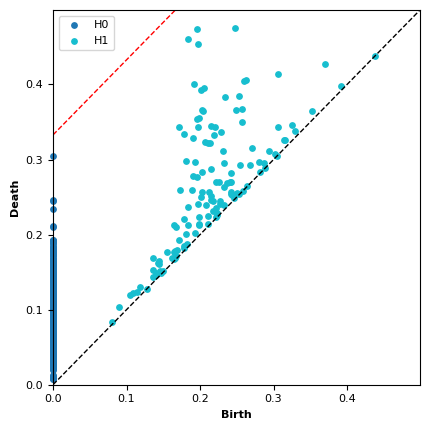

In [31]:
# Sample shape
sample = sample_sphere(n=500, hollow=True)

# Perform TDA
params = TDAParameters()
params.max_homo = 1
params.dtype     = np.float64
torch_dtype      = torch.float64 if params.dtype == np.float64 else torch.float32
threshold        = 0.7
latent_series    = [
    torch.tensor(sample[i:i+1,:], dtype=torch_dtype)
    for i in range(len(sample))
]
diagram, _ = get_diagram(latent_series=latent_series, dtype=params.dtype, max_homo=params.max_homo)

# show persistence diagram
print(f'{get_max_finite_death(diagram) = }')
plot_diagram(diagram=diagram, threshold=threshold)


In [32]:
# Betti numbers
betti_nums = get_betti_nums(diagram, threshold)
print(f'betti_nums = {betti_nums}')

# Now the interactive 3D scatter
x, y, z = sample[:,0], sample[:,1], sample[:,2]

fig = px.scatter_3d(
    x=x, y=y, z=z,
    labels={'x': 'X', 'y': 'Y', 'z': 'Z'},
    width=600, height=600,
)
fig.update_traces(marker={'size': 3})
# lock axes to equal scale
rng = max(x.max()-x.min(), y.max()-y.min(), z.max()-z.min())/2
center = [(a.max()+a.min())/2 for a in (x,y,z)]
axis_kwargs = [
    {'range': (center[i]-rng, center[i]+rng)}
    for i in range(3)
]

fig.update_layout(scene={
    'xaxis': axis_kwargs[0],
    'yaxis': axis_kwargs[1],
    'zaxis': axis_kwargs[2],
    'aspectmode': 'manual',
    'aspectratio': {'x': 1, 'y': 1, 'z': 1}
})
fig.show()

betti_nums = [1 0]


In [33]:
from src.utils.maze_loading import load_mazes
from src.utils.model_loading import load_model
from src.utils.config import Hyperparameters, TDAParameters

# Load mazes
hyperparams = Hyperparameters()
hyperparams.maze_size = 19
hyperparams.num_mazes = 100
inputs, solutions = load_mazes(params=hyperparams)

# Load model
#model = load_model(pretrained='models/dt_net/original.pth')
model = load_model(pretrained='models/pi_net/original.pth')

# Get latent series
tda_params = TDAParameters()
tda_params.iters = list(range(3001,3400))
maze_index = 44
input = inputs[maze_index:maze_index+1]
latent = model.input_to_latent(inputs=input)
latent_series = model.latent_forward(latents=latent, inputs=input, iters=tda_params.iters)
output = model.latent_to_output(latents=latent)
prediction = model.output_to_prediction(outputs=output, inputs=input)
print(f'{sum(latent_series).sum().item() = }')

# Get persistence diagram
threshold = 0.5
diagram, _ = get_diagram(latent_series=latent_series, dtype=tda_params.dtype, max_homo=tda_params.max_homo)
print(get_betti_nums(diagram=diagram, threshold=threshold))
plot_diagram(diagram=diagram, threshold=threshold)

2025-06-09 12:09:52,750 - src.utils.maze_loading - INFO - Attempting 100 mazes to generate 100 mazes with size: 19, percolation: 0.0, and deadend_start: True
2025-06-09 12:09:52,857 - src.utils.maze_loading - INFO - Loaded 100 mazes with size: 19, percolation: 0.0, and deadend_start: True
2025-06-09 12:09:52,911 - src.utils.model_loading - INFO - Loaded pi_net from models/pi_net/original.pth to device: cuda:0
2025-06-09 12:09:53,232 - src.utils.tda - INFO - Performing TDA with embed_dim = 0, delay = 1, and X.shape = (399, 128, 44, 44) (0.791GB)
2025-06-09 12:09:53,233 - src.utils.tda - INFO - Flattened X.shape = (399, 247808)


sum(latent_series).sum().item() = 4424911.0


2025-06-09 12:09:54,454 - src.utils.tda - INFO - Reduced X.shape = (399, 399) (0.001GB)
2025-06-09 12:09:54,522 - src.utils.tda - INFO - Computed distance_matrix.shape = (399, 399) with max_distance = 0.000


[1 0]


In [34]:
from src.utils.tda import get_pca
pca = get_pca(X=latent_series, n=3)

# Now the interactive 3D scatter
pc1, pc2, pc3 = pca[:,0], pca[:,1], pca[:,2]

fig = px.scatter_3d(
    x=pc1, y=pc2, z=pc3,
    labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'},
    width=600, height=600,
)
fig.update_traces(marker={'size': 3})
# lock axes to equal scale
rng = max(pc1.max()-pc1.min(), pc2.max()-pc2.min(), pc3.max()-pc3.min())/2
center = [(a.max()+a.min())/2 for a in (pc1, pc2, pc3)]
axis_kwargs = [
    {'range': (center[i]-rng, center[i]+rng)}
    for i in range(3)
]

fig.update_layout(scene={
    'xaxis_title':'PC1',
    'yaxis_title':'PC2',
    'zaxis_title':'PC3',
    'aspectmode': 'manual',
    'aspectratio': {'x': 1, 'y': 1, 'z': 1}
})
fig.show()


/home/brandon/robust-maze-learning/src/utils/tda.py:425: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



<IPython.core.display.Javascript object>

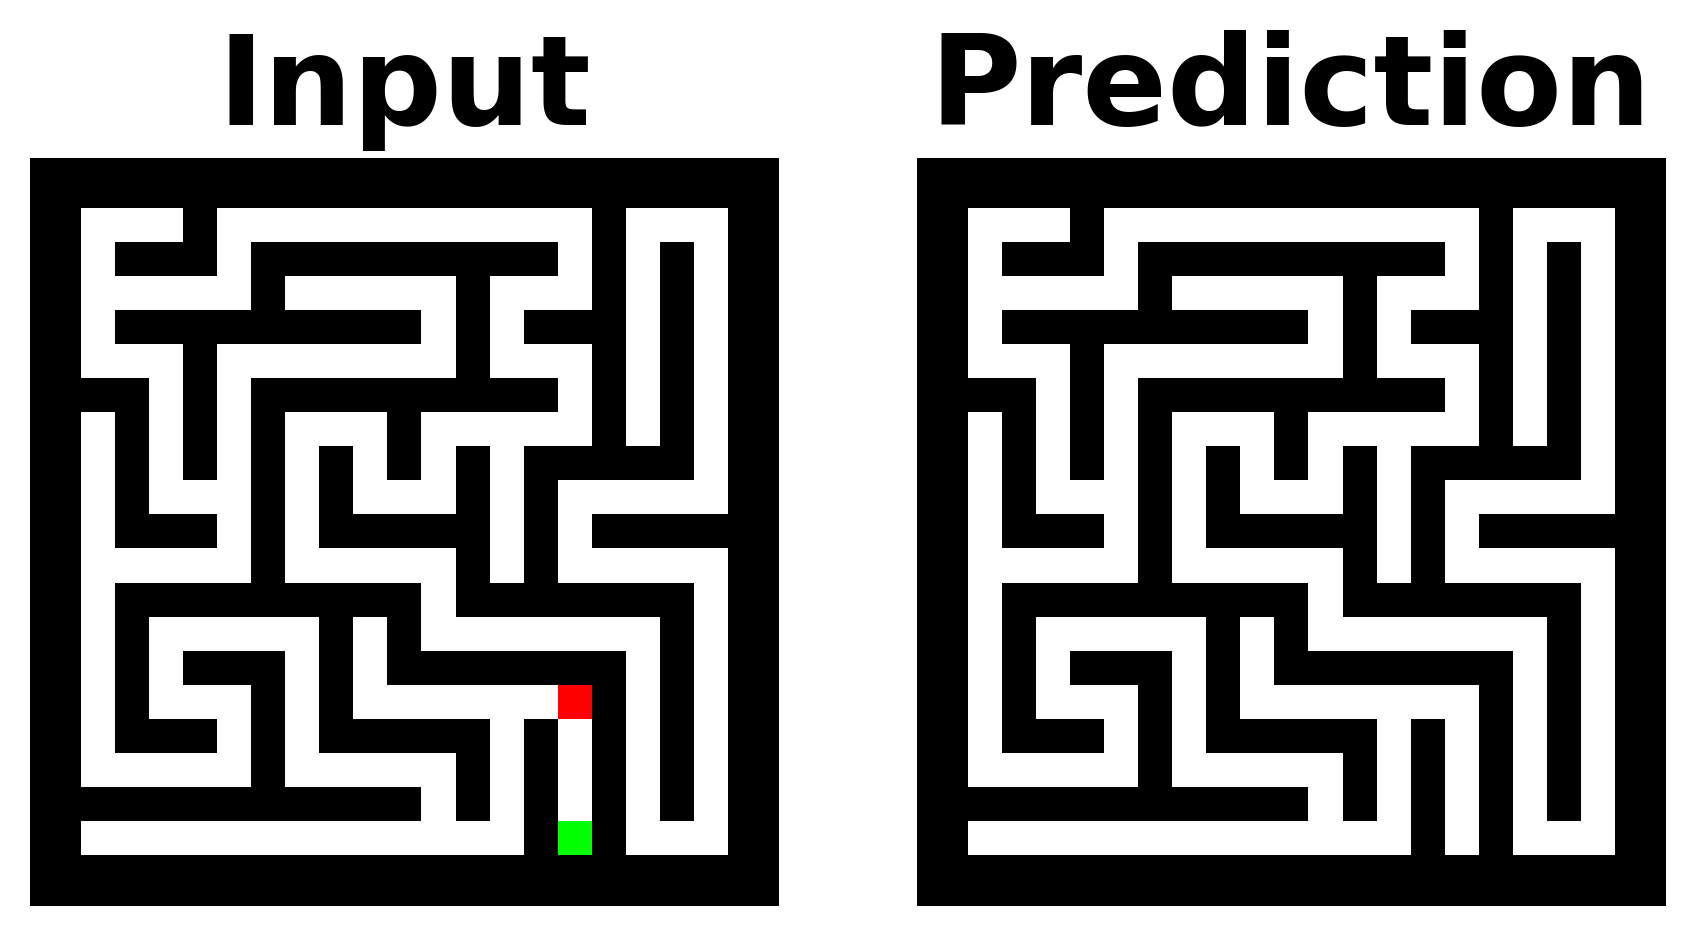

In [35]:
from src.utils.analysis import plot_mazes

plot_mazes((('Input', input), ('Prediction', prediction)))
